### Capstone Presentation

__First:__ Go out and find a dataset of interest. It could be from one of our recommended resources, some other aggregation, or scraped yourself. Just make sure it has lots of variables in it, including an outcome of interest to you.

__Second:__ Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.

__Third:__ Model your outcome of interest. You should try several different approaches and really work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. Make sure to think about explanatory versus predictive power and experiment with both.

__Deliverable:__ Prepare a slide deck and 15 minute presentation that guides viewers through your model. Be sure to cover a few specific things:
- A specified research question your model addresses
- How you chose your model specification and what alternatives you compared it to
- The practical uses of your model for an audience of interest
- Any weak points or shortcomings of your model

## 1.1 Dataset: Ames, Iowa Housing Market Data

__Abstract Excerpt:__

This paper presents a data set describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.

__Full Description:__

https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

__Data Source:__

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Kaggle API: >_ kaggle competitions download -c house-prices-advanced-regression-techniques

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

#display options
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')
sns.set_palette('deep')

## 1.2 Upload Data

In [2]:
train_raw = pd.read_csv('train.csv')

#set df to manipulate
train = train_raw
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

__Needs attention__

Right off the bat there are a few issues to look into:
- Capital letters in variables names and text data
- Null values
- Datatypes

## 2.1 Data Cleaning

### Basics

In [4]:
#lowercase column names
train.columns = [x.lower() for x in train.columns]

#find object datatypes and strip whitespace
to_strip = train.select_dtypes(include='object')
train[to_strip.columns] = to_strip.apply(lambda x: x.str.strip())

### Missingness

- Check for target variable missingness, drop missing rows
- Check for missing values in remaining columns, decide how to handle

In [5]:
#target variable missingness
print('saleprice null: {}'.format(train['saleprice'].isnull().sum()))

#feature missingness
missing_data = train.isnull().sum().sort_values(ascending=False)
missing_data = missing_data.reset_index()
missing_data.columns = ['variable','rows_missing']
missing_data = missing_data[missing_data['rows_missing'] > 0]
missing_data

saleprice null: 0


,variable,rows_missing
0,poolqc,1453
1,miscfeature,1406
2,alley,1369
3,fence,1179
4,fireplacequ,690
5,lotfrontage,259
6,garagecond,81
7,garagetype,81
8,garageyrblt,81
9,garagefinish,81


### Handle missingness
__Drops:__
- Only one electrical value is missing, drop row

__Categorical:__ classes that categorical variables can take are found in the file 'data_description.txt'. The NA class indicates the property does not have any of the feature in question, fill NAs with relevant text for dummy variables
- poolqc: pool quality
- miscfeature: miscellaneous feature not covered in other categories
- alley: type of alley access to property
- fence: fence quality
- fireplacequ: fireplace quality
- garagecond: garage condition
- garagetype: garage location
- garagefinish: interior finish of garage
- garagequal: garage quality
- bsmtexposure: refers to walkout or garden level walls
- bsmtfintype1: rating of basement finished area
- bsmtfintype2: rating of basement finished area (if multiple types)
- bsmtcond: evaluates the general condition of the basement
- bsmtqual: evaluates the height of the basement (in inches, Excellent >= 100, Poor < 70)
- masvnrtype: masonry veneer type

__Continuous:__ fill NAs with 0
- lotfrontage: linear feet of street connected to property
- garageyrblt: year garage was built
- masvnrarea: masonry veneer area in square feet

In [6]:
#drop
train.dropna(subset=['electrical'], inplace=True)

#categorical
train['poolqc'].fillna('no_pool', inplace=True)
train['miscfeature'].fillna('no_miscfeat', inplace=True)
train['alley'].fillna('no_access', inplace=True)
train['fence'].fillna('no_fence', inplace=True)
train['fireplacequ'].fillna('no_fireplace', inplace=True)
train['garagecond'].fillna('no_garage', inplace=True)
train['garagetype'].fillna('no_garage', inplace=True)
train['garagefinish'].fillna('no_garage', inplace=True)
train['garagequal'].fillna('no_garage', inplace=True)
train['bsmtexposure'].fillna('no_bsmt', inplace=True)
train['bsmtfintype1'].fillna('no_bsmt', inplace=True)
train['bsmtfintype2'].fillna('no_bsmt', inplace=True)
train['bsmtcond'].fillna('no_bsmt', inplace=True)
train['bsmtqual'].fillna('no_bsmt', inplace=True)
train['masvnrtype'].fillna('no_masvnr', inplace=True)

#continuous
train['lotfrontage'].fillna(0, inplace=True)
train['garageyrblt'].fillna(0, inplace=True)
train['masvnrarea'].fillna(0, inplace=True)

### Get dummies for categorical variables

In [7]:
#  ***only run this cell once!!!***
categoricals = ['mssubclass','mszoning','street','alley',
                'lotshape','landcontour','utilities','lotconfig',
                'landslope','neighborhood','condition1','condition2',
                'bldgtype','housestyle','overallqual','overallcond',
                'roofstyle','roofmatl','exterior1st','exterior2nd',
                'masvnrtype','exterqual','extercond','foundation',
                'bsmtqual','bsmtcond','bsmtexposure','bsmtfintype1',
                'bsmtfintype2','heating','heatingqc','centralair',
                'electrical','kitchenqual','functional','fireplacequ',
                'garagetype','garagefinish','garagequal','garagecond',
                'paveddrive','poolqc','fence','miscfeature',
                'saletype','salecondition']

cat_dummies = pd.get_dummies(train[categoricals])
train = pd.concat([train, cat_dummies], axis=1)

#drop now superfluous original categoricals
train.drop(categoricals, axis=1, inplace=True)

In [8]:
#check column datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Columns: 302 entries, id to salecondition_Partial
dtypes: float64(3), int64(32), uint8(267)
memory usage: 790.8 KB


In [9]:
#float to int
df_temp = train.select_dtypes(include='float64')
vars_float = list(df_temp.columns.get_values())
train[vars_float] = train[vars_float].astype('int64')

#uint8 to int
df_temp = train.select_dtypes(include='uint8')
vars_uint8 = list(df_temp.columns.get_values())
train[vars_uint8] = train[vars_uint8].astype('int64')

#check results
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Columns: 302 entries, id to salecondition_Partial
dtypes: int64(302)
memory usage: 3.4 MB


## 2.2 Data Exploration

### Target Variable Distribution

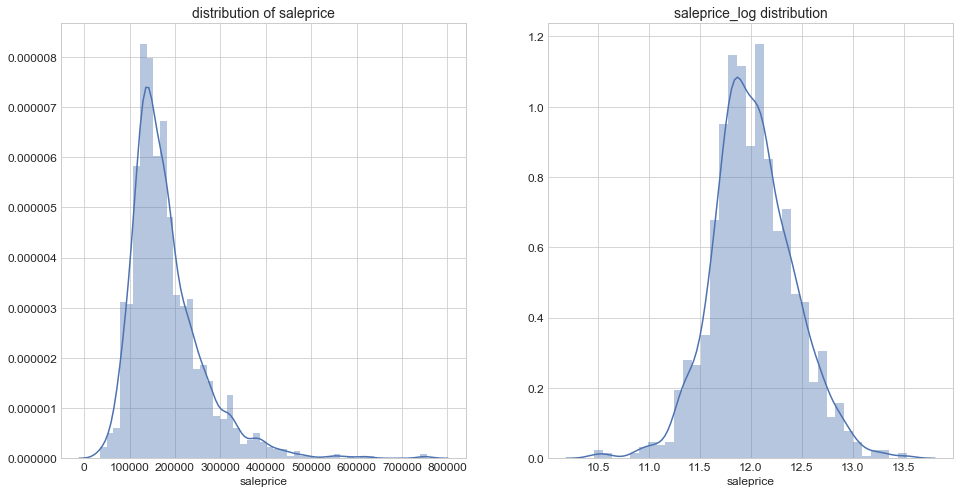

In [10]:
plt.figure(figsize=(16,8))

plt.subplot(121)
sns.distplot(train['saleprice'])
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('saleprice', size=12)
plt.title('distribution of saleprice', size=14)

#log saleprice to get a better looking distribution
saleprice_log = np.log(train['saleprice'])

plt.subplot(122)
sns.distplot(saleprice_log)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('saleprice', size=12)
plt.title('saleprice_log distribution', size=14)

plt.show()

__Result:__
- Original saleprice distribution is skewed and peaked
- Log sale price looks like a significant improvement

In [11]:
#add saleprice_log to df
train['saleprice_log'] = saleprice_log
train.head()

,id,lotfrontage,lotarea,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,...,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial,saleprice_log
0,1,65,8450,2003,2003,196,706,0,150,856,...,0,0,1,0,0,0,0,1,0,12.247694
1,2,80,9600,1976,1976,0,978,0,284,1262,...,0,0,1,0,0,0,0,1,0,12.109011
2,3,68,11250,2001,2002,162,486,0,434,920,...,0,0,1,0,0,0,0,1,0,12.317167
3,4,60,9550,1915,1970,0,216,0,540,756,...,0,0,1,1,0,0,0,0,0,11.849398
4,5,84,14260,2000,2000,350,655,0,490,1145,...,0,0,1,0,0,0,0,1,0,12.429216


In [12]:
#instantiate and train vanilla linear regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = train.drop(['saleprice', 'saleprice_log'], axis=1)
y = train['saleprice_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#fit LR and evaluate performance
lr = LinearRegression().fit(X_train, y_train)
scores_lr = cross_val_score(lr, X_train, y_train, cv=10)

y_train_lr_ = lr.predict(X_train) 
rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_lr_))

print('LR train score array:\n',scores_lr)
print('\nLR train score array mean:\n',np.mean(scores_lr))
print('\nLR train RMSE:\n',rmse_lr)

LR train score array:
 [0.8873854  0.92334159 0.70845455 0.79843047 0.91884622 0.65351869
 0.92125589 0.79281634 0.85760907 0.84469389]

LR train score array mean:
 0.8306352093867423

LR train RMSE:
 0.09602059229765945


In [13]:
#fit & eval test set
lr.fit(X_test, y_test)
scores_lr = cross_val_score(lr, X_test, y_test, cv=10)

y_test_lr_ = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_lr_))

print('LR test score array:\n',scores_lr)
print('\nLR test score array mean:\n',np.mean(scores_lr))
print('\nLR test RMSE:\n',rmse_lr)

LR test score array:
 [-0.63429464  0.29635769  0.70387501 -5.84783595  0.60525665  0.55204891
  0.19045865  0.44516549  0.81148167  0.53194446]

LR test score array mean:
 -0.2345542058255723

LR test RMSE:
 0.055018804911422324


__Result:__ base linear regression model leaves a lot to be desired; both in accuracy and in the extent to which it is overfitting. Check results against assumptions to aid in feature selection/engineering and model selection

### Regression Assumptions
- Linear relationship between features and outcome
- Normally distributed residual
- Homoscedasticity
- Low multicollinearity

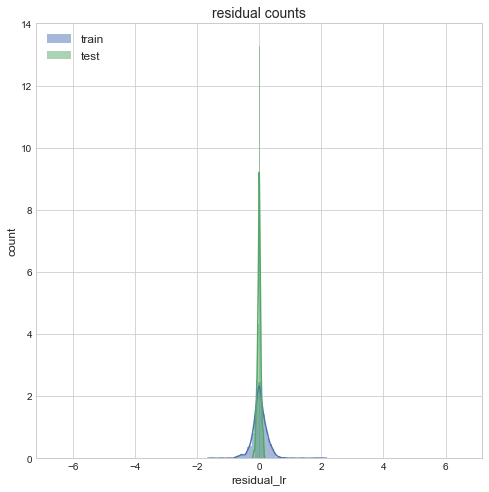

In [14]:
#error distribution
y_train_lr_ = lr.predict(X_train)
residual_train_lr = y_train - y_train_lr_
y_test_lr_ = lr.predict(X_test)
residual_test_lr = y_test - y_test_lr_

plt.figure(figsize=(8,8))
sns.distplot(residual_train_lr, hist_kws={'alpha':0.5}, label='train')
sns.distplot(residual_test_lr, hist_kws={'alpha':0.5}, label='test')
plt.xlabel('residual_lr',size=12)
plt.ylabel('count', size=12)
plt.title('residual counts', size=14)
plt.legend(loc='upper left', prop={'size':12})
plt.axis('equal')
plt.xlim([-7,7])
plt.ylim([0,14])

plt.show()

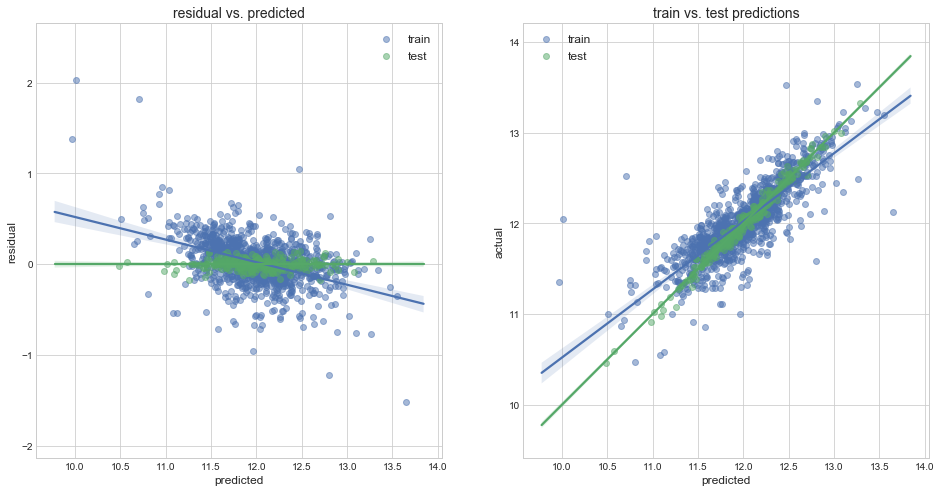

In [15]:
# ***double check axes aren't mixed up when brain is working again***

#homo/heteroscedastic error distribution
plt.figure(figsize=(16,8))

plt.subplot(121)
sns.regplot(x=y_train_lr_,
            y=residual_train_lr,
            scatter_kws={'alpha':0.5},
            label='train')
sns.regplot(x=y_test_lr_,
            y=residual_test_lr,
            scatter_kws={'alpha':0.5},
            label='test')
plt.xlabel('predicted', size=12)
plt.ylabel('residual', size=12)
plt.title('residual vs. predicted', size=14)
plt.legend(loc='upper right', prop={'size':12})
plt.axis('equal')

plt.subplot(122)
sns.regplot(x=y_train_lr_,
            y=y_train,
            scatter_kws={'alpha':0.5},
            label = 'train')
sns.regplot(x=y_test_lr_,
            y=y_test,
            scatter_kws={'alpha':0.5},
            label = 'test')
plt.xlabel('predicted', size=12)
plt.ylabel('actual', size=12)
plt.title('train vs. test predictions', size=14)
plt.legend(loc='upper left', prop={'size':12})
plt.axis('equal')

plt.show()

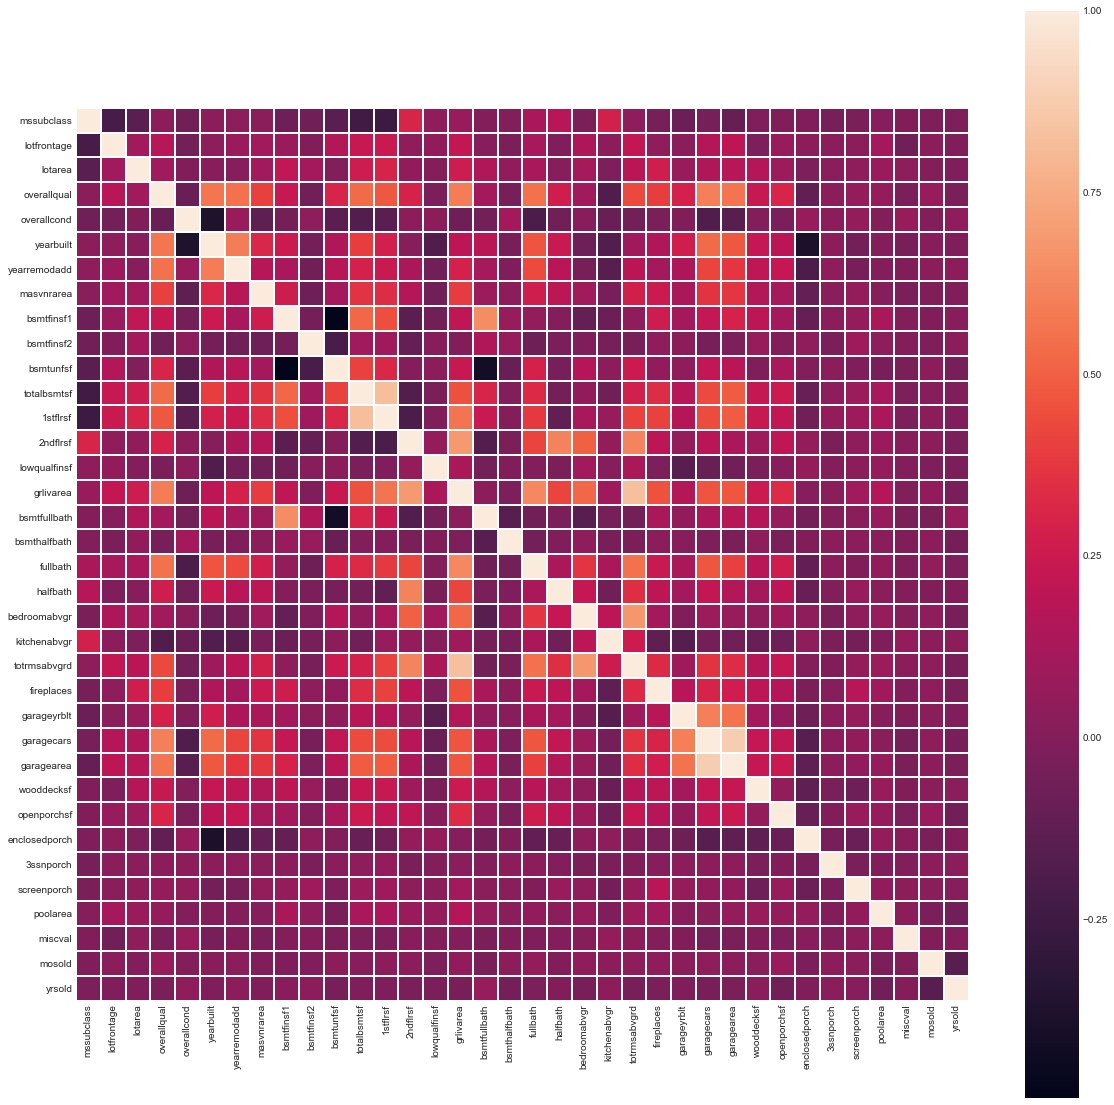

In [16]:
#multicollinearity
df_corr = train_raw.drop(['id','saleprice'],1)
plt.figure(figsize=(20,20))
sns.heatmap(df_corr.corr(), linecolor='white', linewidths=1, square=True)
plt.show()

In [17]:
c = df_corr.corr()
s = c.unstack()
so = pd.DataFrame(s.sort_values(ascending=False))
so = so.reset_index()
so.columns = ['var1', 'var2', 'corr']
so = so[so['corr'] < 1]
so.drop_duplicates(subset='corr', keep='first', inplace=True)

#set some dfs for positively correlated variables
corr_strong = so[so['corr'] >= 0.7]
corr_mod = so[(so['corr'] < .7) & (so['corr'] >= .5)]
corr_weak = so[(so['corr'] < .5) & (so['corr'] >= .3)]
corr_pos = pd.concat([corr_strong,corr_mod,corr_weak])
print(len(corr_strong) + len(corr_mod) + len(corr_weak))
print(len(corr_pos))

72
72


In [18]:
corr_strong

,var1,var2,corr
36,garagearea,garagecars,0.882613
38,grlivarea,totrmsabvgrd,0.825576
40,1stflrsf,totalbsmtsf,0.819393


- garagearea and garagecars: choose one, both tell more or less the same information

In [19]:
corr_mod

,var1,var2,corr
42,grlivarea,2ndflrsf,0.687726
44,totrmsabvgrd,bedroomabvgr,0.676613
46,bsmtfullbath,bsmtfinsf1,0.649025
48,fullbath,grlivarea,0.630283
50,totrmsabvgrd,2ndflrsf,0.616400
52,halfbath,2ndflrsf,0.609551
54,overallqual,garagecars,0.600991
56,garageyrblt,garagecars,0.597978
58,overallqual,grlivarea,0.593021
60,yearremodadd,yearbuilt,0.592512
